In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install contractions


In [3]:
pip install nltk


In [4]:
pip install emoji --upgrade


In [5]:
pip install transformers

## **Section 2 : Text cleaning, Tokenization , Stemming**

In [2]:
import re
import emoji

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

import contractions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import pandas as pd
import json
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [8]:
print("pandas version",pd.__version__)
print("json version",json.__version__)
print("numpy version",np.__version__)

pandas version 1.3.5
json version 2.0.9
numpy version 1.21.6


In [9]:
train = pd.read_csv('/content/gdrive/MyDrive/train.csv', names= ('stars','text'))
test = pd.read_csv('/content/gdrive/MyDrive/test.csv', names= ('stars','text'))

In [10]:
train.head(10)

,stars,text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...
5,5,Top notch doctor in a top notch practice. Can'...
6,5,Dr. Eric Goldberg is a fantastic doctor who ha...
7,1,I'm writing this review to give you a heads up...
8,2,Wing sauce is like water. Pretty much a lot of...
9,3,Decent range somewhat close to the city. The ...


In [11]:
test.head()

,stars,text
0,1,I got 'new' tires from them and within two wee...
1,1,Don't waste your time. We had two different p...
2,1,All I can say is the worst! We were the only 2...
3,1,I have been to this restaurant twice and was d...
4,1,Food was NOT GOOD at all! My husband & I ate h...


In [12]:
# replace emojis with a meaningful text
def demojize(text):
  text = emoji.demojize(text)
  return text

# replace urls with blank (Removing urls)
def replace_url(text, default_replace=""):
  text = re.sub('(http|https):\/\/\S+', default_replace, text)
  return text

# replace hashtag with blank (removing hashtag)
def replace_hashtag(text, default_replace=""):
  text = re.sub('#+', default_replace, text)
  return text


# handle capitalized words (convert to lower case)
def to_lowercase(text):
  text = text.lower()
  return text

# for example word loooooook becomes look ; loooovee becomes love
def word_repetition(text):
  text = re.sub(r'(.)\1+', r'\1\1', text)
  return text

# replace punctuations with default value (remove punctuation)
def punct_repetition(text, default_replace=""):
  text = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, text)
  return text


#  replaces contractions with their extended forms by using the contractions package
def fix_contractions(text):
  for k, v in contractions.contractions_dict.items():
    text = text.replace(k, v)
  return text

In [13]:
#custom tokenize function
def custom_tokenize(text,
                    keep_punct = False,
                    keep_alnum = False,
                    keep_stop = False):
  
  token_list = word_tokenize(text)

  if not keep_punct:
    token_list = [token for token in token_list
                  if token not in string.punctuation]

  if not keep_alnum:
    token_list = [token for token in token_list if token.isalpha()]
  
  if not keep_stop:
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]

  return token_list

#takes the list of tokens as input and returns a list of stemmed tokens
def stem_tokens(tokens, stemmer):
  token_list = []
  for token in tokens:
    token_list.append(stemmer.stem(token))
  return token_list

In [14]:
def process_text(text, verbose=False):
  if verbose: print("Initial text: {}".format(text))

  ## Text Features
  
  
  text = replace_url(text) # replace url
  text = replace_hashtag(text) # replace hashtag
  if verbose: print("Post Text processing text: {}".format(text))

  ## Word Features
  text = to_lowercase(text) # lower case
  text = fix_contractions(text) # replace contractions
  text = punct_repetition(text) # replace punctuation repetition
  text = word_repetition(text) # replace word repetition
  text = demojize(text) # replace emojis
  if verbose: print("Post Word processing text: {}".format(text))

  ## Tokenization & Stemming
  tokens = custom_tokenize(text, keep_alnum=False, keep_stop=False) # tokenize
  stemmer = SnowballStemmer("english") # define stemmer
  stem = stem_tokens(tokens, stemmer) # stem tokens

  return stem

In [ ]:
train["tokens"] = train["text"].apply(process_text)

In [ ]:
train["text_sentiment"] = train["stars"]

In [ ]:
X_train = train["tokens"].tolist()
y_train= train["text_sentiment"].tolist()

train.head(10)



In [ ]:
test["tokens"] = test["text"].apply(process_text)
test["text_sentiment"] = test["stars"]

# representing data frames in two lists: one for the text tokens (X) and one for the text sentiment (y)

X_test = test["tokens"].tolist()
y_test = test["text_sentiment"].tolist()

test.head(10)

## **Section 3: TF-IDF Vectorization**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#build the TF-IDF vectorizer with the corpus
def fit_tfidf(text_corpus):
  tf_vect = TfidfVectorizer(preprocessor=lambda x: x,
                            tokenizer=lambda x: x)
  tf_vect.fit(text_corpus)
  return tf_vect

## **Section 4: Model - SVM and Logistic Regression**

# SVM

In [22]:
from sklearn.svm import LinearSVC
def fit_svc(X_train, y_train):
  model = LinearSVC()
  model.fit(X_train, y_train)
  return model

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# fit a Logistic Regression model on X and y training data
def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

Fitting tf-idf 


In [23]:
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [24]:

model_svc_tf = fit_svc(X_train_tf, y_train)

In [ ]:
model_lr_tf = fit_lr(X_train_tf, y_train)

## **Section 5 : Performance matrics**

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
import seaborn as sn

# plot the confusion matrix for the different models 
def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

SVM - Performance

In [26]:
y_pred_svc_tf = model_svc_tf.predict(X_test_tf)
print("prediction:",list(y_pred_svc_tf[:10]))
print("Actual:    ",np.array(y_test[:10]))

prediction: [1, 1, 1, 1, 1, 3, 3, 5, 5, 4]
Actual:     [1 1 1 1 1 3 2 4 4 3]


In [27]:
print("SVC Model Accuracy TF-IDF: {:.2%}".format(accuracy_score(y_test, y_pred_svc_tf)))
accuracy_svc_tf = accuracy_score(y_test, y_pred_svc_tf)

SVC Model Accuracy TF-IDF: 55.52%


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_svc_tf))

              precision    recall  f1-score   support

           1       0.65      0.77      0.71     10000
           2       0.50      0.44      0.47     10000
           3       0.48      0.42      0.45     10000
           4       0.47      0.43      0.45     10000
           5       0.62      0.72      0.66     10000

    accuracy                           0.56     50000
   macro avg       0.55      0.56      0.55     50000
weighted avg       0.55      0.56      0.55     50000



<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

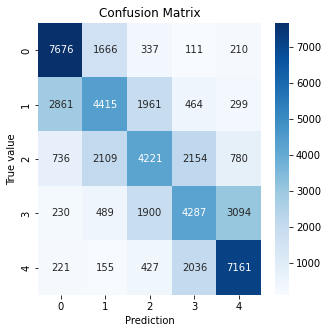

In [30]:
plot_confusion(confusion_matrix(y_test, y_pred_svc_tf))

Logistic Regression - Performnace

In [31]:
from sklearn.linear_model import LogisticRegression

# fit a Logistic Regression model on X and y training data
def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

In [32]:
model_lr_tf = fit_lr(X_train_tf, y_train)

In [33]:
y_pred_lr_tf = model_lr_tf.predict(X_test_tf)

In [34]:
print("LR Model Accuracy TF-IDF: {:.2%}".format(accuracy_score(y_test, y_pred_lr_tf)))
accuracy_lr_tf = accuracy_score(y_test, y_pred_lr_tf)

LR Model Accuracy TF-IDF: 57.70%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

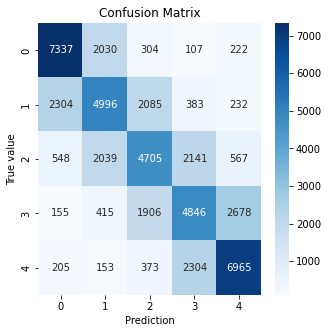

In [35]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_tf))

([<matplotlib.axis.XTick at 0x7ff92dee0910>,
 [Text(0, 0, 'Logistic Reg'), Text(0, 0, 'SVM')])

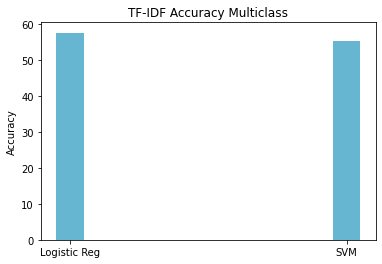

In [3]:
accuracy_lr_tf = 57.70
accuracy_svc_tf = 55.52
ax = plt.subplot(111)
ax.set_title('TF-IDF Accuracy Multiclass')
plt.ylabel('Accuracy')
models = ['Logistic Reg','SVM']
values = [accuracy_lr_tf,accuracy_svc_tf]
model = np.arange(len(models))
plt.bar(model,values,align='center',width=0.10,alpha=0.7,color='#2596be')
plt.xticks (model,models)